In [ ]:
# Turn on multi-threading on your computer for faster calculation 
%env OMP_NUM_THREADS = 4

env: OMP_NUM_THREADS=4


In [ ]:
# !pip install gplearn

import copy
import math
import pandas as pd
import numpy as np
import statsmodels.api as sm
import sklearn as sk
import matplotlib as mp
import random
import seaborn as sns
from scipy import stats
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from pandas import Series
from numpy.random import randn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV,KFold,RandomizedSearchCV,StratifiedKFold,cross_val_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report, confusion_matrix, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [ ]:
train = pd.read_excel("MMA867 A3 -- credit data.xlsx")
pred = pd.read_excel("MMA867 A3 -- new applications.xlsx")
pred.info()

feature = pd.read_excel("MMA867 A3 -- credit data_New.xlsx")

pd.options.display.max_columns = None
pd.options.display.max_rows = None
feature.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         1000 non-null   object
 1   LIMIT_BAL  1000 non-null   int64 
 2   SEX        1000 non-null   int64 
 3   EDUCATION  1000 non-null   int64 
 4   MARRIAGE   1000 non-null   int64 
 5   AGE        1000 non-null   int64 
 6   PAY_1      1000 non-null   int64 
 7   PAY_2      1000 non-null   int64 
 8   PAY_3      1000 non-null   int64 
 9   PAY_4      1000 non-null   int64 
 10  PAY_5      1000 non-null   int64 
 11  PAY_6      1000 non-null   int64 
 12  BILL_AMT1  1000 non-null   int64 
 13  BILL_AMT2  1000 non-null   int64 
 14  BILL_AMT3  1000 non-null   int64 
 15  BILL_AMT4  1000 non-null   int64 
 16  BILL_AMT5  1000 non-null   int64 
 17  BILL_AMT6  1000 non-null   int64 
 18  PAY_AMT1   1000 non-null   int64 
 19  PAY_AMT2   1000 non-null   int64 
 20  PAY_AMT3   1000 non-null   int6

In [ ]:
feature.rename(columns={"default_0": "DEFAULT"}, inplace=True)

In [ ]:
feature.describe() # Count=2500 for all (except default column), hence no missing value

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Active_Months,Bill_Left_1,Bill_Left_2,Bill_Left_3,Bill_Left_4,Bill_Left_5,Bill-Left_6,TimesOFFullpay,Pay_Frequency,Total-bill_Increase,Total_Pay_Increase,PAY-Delay1,PAY_Delay2,PAY_Delay3,PAY_Delay4,PAY_Delay5,PAY_Delay6,Total-Months_Delayed,Average_Delay,Full_Pay_Last3month,DEFAULT
count,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.00000,25000.000000,25000.000000,25000.000000,25000.00000,2.500000e+04,25000.000000,25000.000000,25000.00000,25000.000000,2.500000e+04,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,2.500000e+04,2.500000e+04,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.00000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000
mean,167707.747200,1.602200,1.851560,1.552080,35.452800,-0.022880,-0.140120,-0.168840,-0.22180,-0.266960,-0.294960,51069.432600,49062.62200,4.682910e+04,43117.285480,40149.706600,38739.05348,5689.770480,5.905291e+03,5205.991160,4762.714080,4799.279280,5244.396920,5.395200,45379.662120,4.315733e+04,4.162311e+04,38354.571400,35350.427320,33494.656560,1.474680,0.369804,12330.379120,445.373560,0.354680,0.31676,0.304040,0.260000,0.222560,0.224680,1.682720,0.298951,0.270880,0.220920
std,129824.770037,0.489454,0.787623,0.521861,9.187941,1.127159,1.196889,1.200129,1.17164,1.134189,1.146966,73509.204207,71013.44997,6.911297e+04,63954.284982,60272.889516,59252.74894,17005.778297,2.390309e+04,17749.185055,15380.028492,15553.299352,18030.007025,1.444015,73155.972965,7.260269e+04,6.907471e+04,63880.125565,60160.781308,59886.265363,1.858703,0.821754,43901.358105,22334.973391,0.763378,0.80118,0.793741,0.762957,0.717947,0.710365,3.612636,0.632188,0.444423,0.414875
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.00000,-2.000000,-2.000000,-165580.000000,-69777.00000,-1.572640e+05,-170000.000000,-53007.000000,-339603.00000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,-733744.000000,-1.702347e+06,-8.546410e+05,-667000.000000,-414380.000000,-684896.000000,0.000000,0.000000,-428791.000000,-528666.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,3473.000000,2899.00000,2.604750e+03,2287.750000,1714.000000,1241.50000,1000.000000,8.157500e+02,390.000000,284.000000,249.000000,102.000000,6.000000,693.000000,2.977500e+02,2.257500e+02,206.750000,0.000000,0.000000,0.000000,0.000000,-2938.250000,-390.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,22186.500000,21076.00000,2.002850e+04,19000.000000,18064.000000,16903.00000,2100.000000,2.009500e+03,1800.000000,1500.000000,1500.000000,1500.000000,6.000000,18419.000000,1.801650e+04,1.765050e+04,16874.000000,15451.000000,13732.500000,0.000000,0.000000,932.500000,500.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,67087.750000,64031.50000,6.028625e+04,54833.250000,50350.250000,49332.75000,5010.250000,5.000000e+03,4510.500000,4015.250000,4019.500000,4003.000000,6.000000,62241.500000,5.902525e+04,5.622700e+04,50585.500000,47042.000000,46179.750000,3.000000,0.500000,19684.250000,2003.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,2.000000,0.333333,1.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.00000,8.

In [ ]:
feature.isna().sum()

ID                       0
LIMIT_BAL                0
BILL_AMT1                0
BILL_AMT2                0
BILL_AMT3                0
BILL_AMT4                0
BILL_AMT5                0
BILL_AMT6                0
PAY_AMT1                 0
PAY_AMT2                 0
PAY_AMT3                 0
PAY_AMT4                 0
PAY_AMT5                 0
PAY_AMT6                 0
Bill_Left_1              0
Bill_Left_2              0
Bill_Left_3              0
Bill_Left_4              0
Bill_Left_5              0
Bill-Left_6              0
Pay_Frequency            0
Total-bill_Increase      0
Total_Pay_Increase       0
Total-Months_Delayed     0
Average_Delay            0
DEFAULT                  0
SEX_1                    0
SEX_2                    0
EDUCATION_1              0
EDUCATION_2              0
EDUCATION_3              0
EDUCATION_4              0
MARRIAGE_1               0
MARRIAGE_2               0
MARRIAGE_3               0
AGE_1                    0
AGE_2                    0
A

In [ ]:
feature['EDUCATION'].unique()

array([2, 1, 3, 5, 4, 6, 0])

In [ ]:
feature['EDUCATION']=np.where(feature['EDUCATION'] == 5, 4, feature['EDUCATION'])
feature['EDUCATION']=np.where(feature['EDUCATION'] == 6, 4, feature['EDUCATION'])
feature['EDUCATION']=np.where(feature['EDUCATION'] == 0, 4, feature['EDUCATION'])
feature['EDUCATION'].unique()

array([2, 1, 3, 4])

In [ ]:
feature['MARRIAGE'].unique()

array([1, 2, 3, 0])

In [ ]:
feature['MARRIAGE']=np.where(feature['MARRIAGE'] == 0, 3, feature['MARRIAGE'])
feature['MARRIAGE'].unique()

array([1, 2, 3])

In [ ]:
## Creating a Function to Distribute the Age
def func(x):
    if(x >=20 and x<30 ):
        return 1
    elif(x>=30 and x<40):
        return 2
    elif(x>=40 and x<50):
        return 3
    elif(x>=50 and x<60):
        return 4
    elif(x>=60 and x<=80):
        return 5
    
feature['AGE'] = feature['AGE'].apply(func)

In [ ]:
feature['SEX'] = feature['SEX'].astype('category')
feature['AGE'] = feature['AGE'].astype('category')
feature['EDUCATION'] = feature['EDUCATION'].astype('category')
feature['MARRIAGE'] = feature['MARRIAGE'].astype('category')
feature['PAY_1'] = feature['PAY_1'].astype('category')
feature['PAY_2'] = feature['PAY_2'].astype('category')
feature['PAY_3'] = feature['PAY_3'].astype('category')
feature['PAY_4'] = feature['PAY_4'].astype('category')
feature['PAY_5'] = feature['PAY_5'].astype('category')
feature['PAY_6'] = feature['PAY_6'].astype('category')
feature['Active_Months'] = feature['Active_Months'].astype('category')
feature['TimesOFFullpay'] = feature['TimesOFFullpay'].astype('category')
feature['PAY-Delay1'] = feature['PAY-Delay1'].astype('category')
feature['PAY_Delay2'] = feature['PAY_Delay2'].astype('category')
feature['PAY_Delay3'] = feature['PAY_Delay3'].astype('category')
feature['PAY_Delay4'] = feature['PAY_Delay4'].astype('category')
feature['PAY_Delay5'] = feature['PAY_Delay5'].astype('category')
feature['PAY_Delay6'] = feature['PAY_Delay6'].astype('category')
feature['Full_Pay_Last3month'] = feature['Full_Pay_Last3month'].astype('category')
# feature['DEFAULT'] = feature['DEFAULT'].astype('category')
feature.info() # let check the result

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 45 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   ID                    25000 non-null  object  
 1   LIMIT_BAL             25000 non-null  int64   
 2   SEX                   25000 non-null  category
 3   EDUCATION             25000 non-null  category
 4   MARRIAGE              25000 non-null  category
 5   AGE                   25000 non-null  category
 6   PAY_1                 25000 non-null  category
 7   PAY_2                 25000 non-null  category
 8   PAY_3                 25000 non-null  category
 9   PAY_4                 25000 non-null  category
 10  PAY_5                 25000 non-null  category
 11  PAY_6                 25000 non-null  category
 12  BILL_AMT1             25000 non-null  int64   
 13  BILL_AMT2             25000 non-null  int64   
 14  BILL_AMT3             25000 non-null  int64   
 15  BI

In [ ]:
# "Cleaning" the data -- wrapping up: creating dummy variables for Categorical Variables ("one hot encoding")
feature = pd.get_dummies(feature, columns = feature.select_dtypes(exclude=['int64','float64', 'object']).columns)
feature.head()                  

,ID,LIMIT_BAL,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Bill_Left_1,Bill_Left_2,Bill_Left_3,Bill_Left_4,Bill_Left_5,Bill-Left_6,Pay_Frequency,Total-bill_Increase,Total_Pay_Increase,Total-Months_Delayed,Average_Delay,DEFAULT,SEX_1,SEX_2,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,AGE_1,AGE_2,AGE_3,AGE_4,AGE_5,PAY_1_-2,PAY_1_-1,PAY_1_0,PAY_1_1,PAY_1_2,PAY_1_3,PAY_1_4,PAY_1_5,PAY_1_6,PAY_1_7,PAY_1_8,PAY_2_-2,PAY_2_-1,PAY_2_0,PAY_2_1,PAY_2_2,PAY_2_3,PAY_2_4,PAY_2_5,PAY_2_6,PAY_2_7,PAY_2_8,PAY_3_-2,PAY_3_-1,PAY_3_0,PAY_3_1,PAY_3_2,PAY_3_3,PAY_3_4,PAY_3_5,PAY_3_6,PAY_3_7,PAY_3_8,PAY_4_-2,PAY_4_-1,PAY_4_0,PAY_4_1,PAY_4_2,PAY_4_3,PAY_4_4,PAY_4_5,PAY_4_6,PAY_4_7,PAY_4_8,PAY_5_-2,PAY_5_-1,PAY_5_0,PAY_5_2,PAY_5_3,PAY_5_4,PAY_5_5,PAY_5_6,PAY_5_7,PAY_5_8,PAY_6_-2,PAY_6_-1,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7,PAY_6_8,Active_Months_0,Active_Months_1,Active_Months_2,Active_Months_3,Active_Months_4,Active_Months_5,Active_Months_6,TimesOFFullpay_0,TimesOFFullpay_1,TimesOFFullpay_2,TimesOFFullpay_3,TimesOFFullpay_4,TimesOFFullpay_5,TimesOFFullpay_6,PAY-Delay1_0,PAY-Delay1_1,PAY-Delay1_2,PAY-Delay1_3,PAY-Delay1_4,PAY-Delay1_5,PAY-Delay1_6,PAY-Delay1_7,PAY-Delay1_8,PAY_Delay2_0,PAY_Delay2_1,PAY_Delay2_2,PAY_Delay2_3,PAY_Delay2_4,PAY_Delay2_5,PAY_Delay2_6,PAY_Delay2_7,PAY_Delay2_8,PAY_Delay3_0,PAY_Delay3_1,PAY_Delay3_2,PAY_Delay3_3,PAY_Delay3_4,PAY_Delay3_5,PAY_Delay3_6,PAY_Delay3_7,PAY_Delay3_8,PAY_Delay4_0,PAY_Delay4_1,PAY_Delay4_2,PAY_Delay4_3,PAY_Delay4_4,PAY_Delay4_5,PAY_Delay4_6,PAY_Delay4_7,PAY_Delay4_8,PAY_Delay5_0,PAY_Delay5_2,PAY_Delay5_3,PAY_Delay5_4,PAY_Delay5_5,PAY_Delay5_6,PAY_Delay5_7,PAY_Delay5_8,PAY_Delay6_0,PAY_Delay6_2,PAY_Delay6_3,PAY_Delay6_4,PAY_Delay6_5,PAY_Delay6_6,PAY_Delay6_7,PAY_Delay6_8,Full_Pay_Last3month_0,Full_Pay_Last3month_1
0,1,20000,3913,3102,689,0,0,0,0,689,0,0,0,0,3913,2413,689,0,0,0,1.000000,3913,0,4,1.333333,1,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
1,2,90000,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,27721,12527,12559,13331,13948,10549,0.000000,13690,-3482,0,0.000000,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
2,3,50000,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,44990,46214,48091,27214,27890,28547,0.000000,17443,1000,0,0.000000,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
3,4,50000,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,6617,-31011,25835,11940,18457,18452,0.166667,-10514,1321,0,0.000000,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
4,5,50000,64400,57069,57608,19394,19619,20024,2500,1815,657,1000,1000,800,61900,55254,56951,18394,18619,19224,0.000000,44376,1700,0,0.000000,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0

In [ ]:
feature.shape

(25000, 172)

In [ ]:
ID = train['ID']

In [ ]:
# splitting train and test data
train_new = feature.iloc[:len(ID), :].reset_index(drop=True)
pred_new = feature.iloc[len(train):, :].reset_index(drop=True)

In [ ]:
print(train_new.shape)
print(pred_new.shape)

(24000, 172)
(1000, 172)


In [ ]:
y = train_new['DEFAULT']
X = train_new.drop(['DEFAULT'], axis = 1)

In [ ]:
X.shape

(24000, 171)

In [ ]:
# Setting seed for the random number generator
np.random.seed(77300)

# split the data randomly into 80% train and 20% test samples 
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, stratify=y)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(19200, 171)
(4800, 171)
(19200,)
(4800,)


In [ ]:
# validation_ID = X_test['ID']
# # validation_ID

In [ ]:
X_train = X_train.drop(['ID'], axis = 1)
X_test = X_test.drop(['ID'], axis = 1)

In [ ]:
y_test.head()

14634    0
7633     1
5598     0
6502     0
20174    0
Name: DEFAULT, dtype: int64

In [ ]:
# define a set of functions to compute the metrics of the model

# ROC curve
def plot_roc(y_test, y_pred):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1, drop_intermediate = False)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([-0.001, 1.001])
    plt.ylim([-0.001, 1.001])
    plt.xlabel('1-Specificity (False Negative Rate)')
    plt.ylabel('Sensitivity (True Positive Rate)')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

# Confusion Matrix returns in the format:  tn, fp, fn, tp = cm[1][1], cm[1][0], cm[0][1], cm[0][0]: tn, fp, fn, tp

# Sensitivity
def custom_sensitivity_score(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm[1][1], cm[1][0], cm[0][1], cm[0][0]
    return (tp/(tp+fn))

# Specificity
def custom_specificity_score(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm[1][1], cm[1][0], cm[0][1], cm[0][0]
    return (tn/(tn+fp))

# Positive Predictive Value
def custom_ppv_score(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm[1][1], cm[1][0], cm[0][1], cm[0][0]
    return (tp/(tp+fp))

# Negative Predictive Value
def custom_npv_score(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm[1][1], cm[1][0], cm[0][1], cm[0][0]
    return (tn/(tn+fn))

# Accuracy
def custom_accuracy_score(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm[1][1], cm[1][0], cm[0][1], cm[0][0]
    return ((tn+tp)/(tn+tp+fn+fp))

In [ ]:
# Select the threshold value -- we will use Т=0.2211 as it is the average probability of retention in our data (5306 "1"s out of 24000 datapoints) 
class_threshold = 0.2211

# Model №1: Logistic regression

In [ ]:
# define the model and call it classifier_LR
classifier_LR = LogisticRegression(solver='liblinear')

# train classifier_LR on the training data
classifier_LR.fit(X_train, y_train)

print('Intercept: ' + str(classifier_LR.intercept_))
print('Coefficients (10 largest and 10 smallest) ')
summary = pd.DataFrame([X_test.columns,classifier_LR.coef_[0]]).transpose().sort_values(by = 1, ascending = False)
summary.columns = ['Variable','Coefficient']
top10positive = summary.head(10) # 10 largest (by value)
top10negative = summary.tail(10) # 10 smallest (by value)
top10list=pd.DataFrame()
top10list= top10list.append(pd.DataFrame(data = top10positive))
top10list= top10list.append(pd.DataFrame(data = top10negative))
top10list

Intercept: [-3.51085748e-08]
Coefficients (10 largest and 10 smallest) 


,Variable,Coefficient
14,Bill_Left_2,1.16477e-05
13,Bill_Left_1,6.83005e-06
16,Bill_Left_4,5.65783e-06
17,Bill_Left_5,5.38618e-06
15,Bill_Left_3,4.638e-06
18,Bill-Left_6,3.15514e-06
5,BILL_AMT5,1.71465e-06
22,Total-Months_Delayed,2.53357e-07
23,Average_Delay,4.3234e-08
118,PAY-Delay1_2,2.45987e-08


In [ ]:
# Use the trained model to predict testing data

y_pred_prob = classifier_LR.predict_proba(X_test)[:,1] # probabilities
y_pred = np.where(y_pred_prob > class_threshold, 1, 0) # applying the threshold rule to classify

# print(y_pred_prob[0:5]) # first 5 probabilities 
# print(y_pred[0:5]) # resultant predicted classification 
# print(y_test[0:5]) # actual outcomes


Metrics of the logistic regression model: 

Confusion matrix: 
[[1654  267]
 [2085  794]]
                                   Accuracy: 0.51
                   SENSITIVITY (aka RECALL): 0.4423642685209949
                 SPECIFICITY (aka FALL-OUT): 0.7483506126295947
 POSITIVE PREDICTIVE VALUE, (aka PRECISION): 0.8610098906819365
                 NEGATIVE PREDICTIVE VALUE): 0.27579020493226813


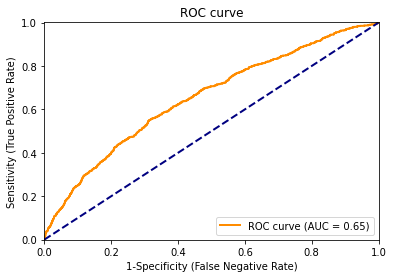

 AUC: 0.6523021094361872


In [ ]:
# Lets look at the model metrics 
print('Metrics of the logistic regression model: \n')

cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix: \n" + str(cm))

print("                                   Accuracy: " + str(custom_accuracy_score(y_test, y_pred))) 
print("                   SENSITIVITY (aka RECALL): " + str(custom_sensitivity_score(y_test, y_pred)))
print("                 SPECIFICITY (aka FALL-OUT): " + str(custom_specificity_score(y_test, y_pred)))
print(" POSITIVE PREDICTIVE VALUE, (aka PRECISION): " + str(custom_ppv_score(y_test, y_pred)))
print("                 NEGATIVE PREDICTIVE VALUE): " + str(custom_npv_score(y_test, y_pred)))

plot_roc(y_test, y_pred_prob)
print(" AUC: " + str(roc_auc_score(y_test, y_pred_prob)))


In [ ]:
# Apply variable selection with Stepwise Recursive Feature Selection 

from sklearn.feature_selection import RFE

rfe = RFE(estimator=classifier_LR, n_features_to_select=30, step=1) 
rfe.fit(X_train, y_train)
ranking = rfe.ranking_.reshape(len(X_train.columns))

# which 30 variables are in the model?
pd.DataFrame([X_test.columns,ranking]).transpose().sort_values(1).head(40)


,0,1
0,LIMIT_BAL,1
116,PAY-Delay1_0,1
125,PAY_Delay2_0,1
134,PAY_Delay3_0,1
143,PAY_Delay4_0,1
152,PAY_Delay5_0,1
22,Total-Months_Delayed,1
21,Total_Pay_Increase,1
20,Total-bill_Increase,1
160,PAY_Delay6_0,1


Metrics of the logistic regression model after variable selection: 

Confusion matrix: 
[[1654  267]
 [2085  794]]
                                   Accuracy: 0.51
                   SENSITIVITY (aka RECALL): 0.4423642685209949
                 SPECIFICITY (aka FALL-OUT): 0.7483506126295947
 POSITIVE PREDICTIVE VALUE, (aka PRECISION): 0.8610098906819365
                 NEGATIVE PREDICTIVE VALUE): 0.27579020493226813


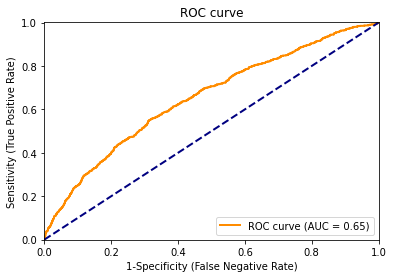

 AUC: 0.6523066467796583


In [ ]:
# Train the model and call it classifier_LR_RFE 
classifier_LR_RFE = rfe.fit(X_train, y_train)

# Use the trained model to predict testing data
y_pred_prob = classifier_LR_RFE.predict_proba(X_test)[:,1] # probabilities
y_pred = np.where(y_pred_prob > class_threshold, 1, 0) # classification


# Lets look at the model metrics after variable selection 
print('Metrics of the logistic regression model after variable selection: \n')

cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix: \n" + str(cm))

print("                                   Accuracy: " + str(custom_accuracy_score(y_test, y_pred))) 
print("                   SENSITIVITY (aka RECALL): " + str(custom_sensitivity_score(y_test, y_pred)))
print("                 SPECIFICITY (aka FALL-OUT): " + str(custom_specificity_score(y_test, y_pred)))
print(" POSITIVE PREDICTIVE VALUE, (aka PRECISION): " + str(custom_ppv_score(y_test, y_pred)))
print("                 NEGATIVE PREDICTIVE VALUE): " + str(custom_npv_score(y_test, y_pred)))

plot_roc(y_test, y_pred_prob)
print(" AUC: " + str(roc_auc_score(y_test, y_pred_prob)))


# Method №2: Classification and Regression Tree, CART (aka "decision tree")

In [ ]:
# Define a CART model and call it classifier_DT
classifier_DT = DecisionTreeClassifier(max_leaf_nodes = 5, random_state=77300) # random_state -- is same as random seed, neede to get the same result every time we rerun

# Train the model classifier_DT on the training data
classifier_DT.fit(X_train, y_train)

#  Use the trained model to predict testing data
y_pred_prob = classifier_DT.predict_proba(X_test)[:,1] # probabilities 
y_pred = np.where(y_pred_prob > class_threshold, 1, 0) # classification

# print(y_pred_prob[0:5]) # first 5 probabilities 
# print(y_pred[0:5]) # resultant predicted classification 
# print(y_test[0:5]) # actual outcomes



CART tree with 5 leafs


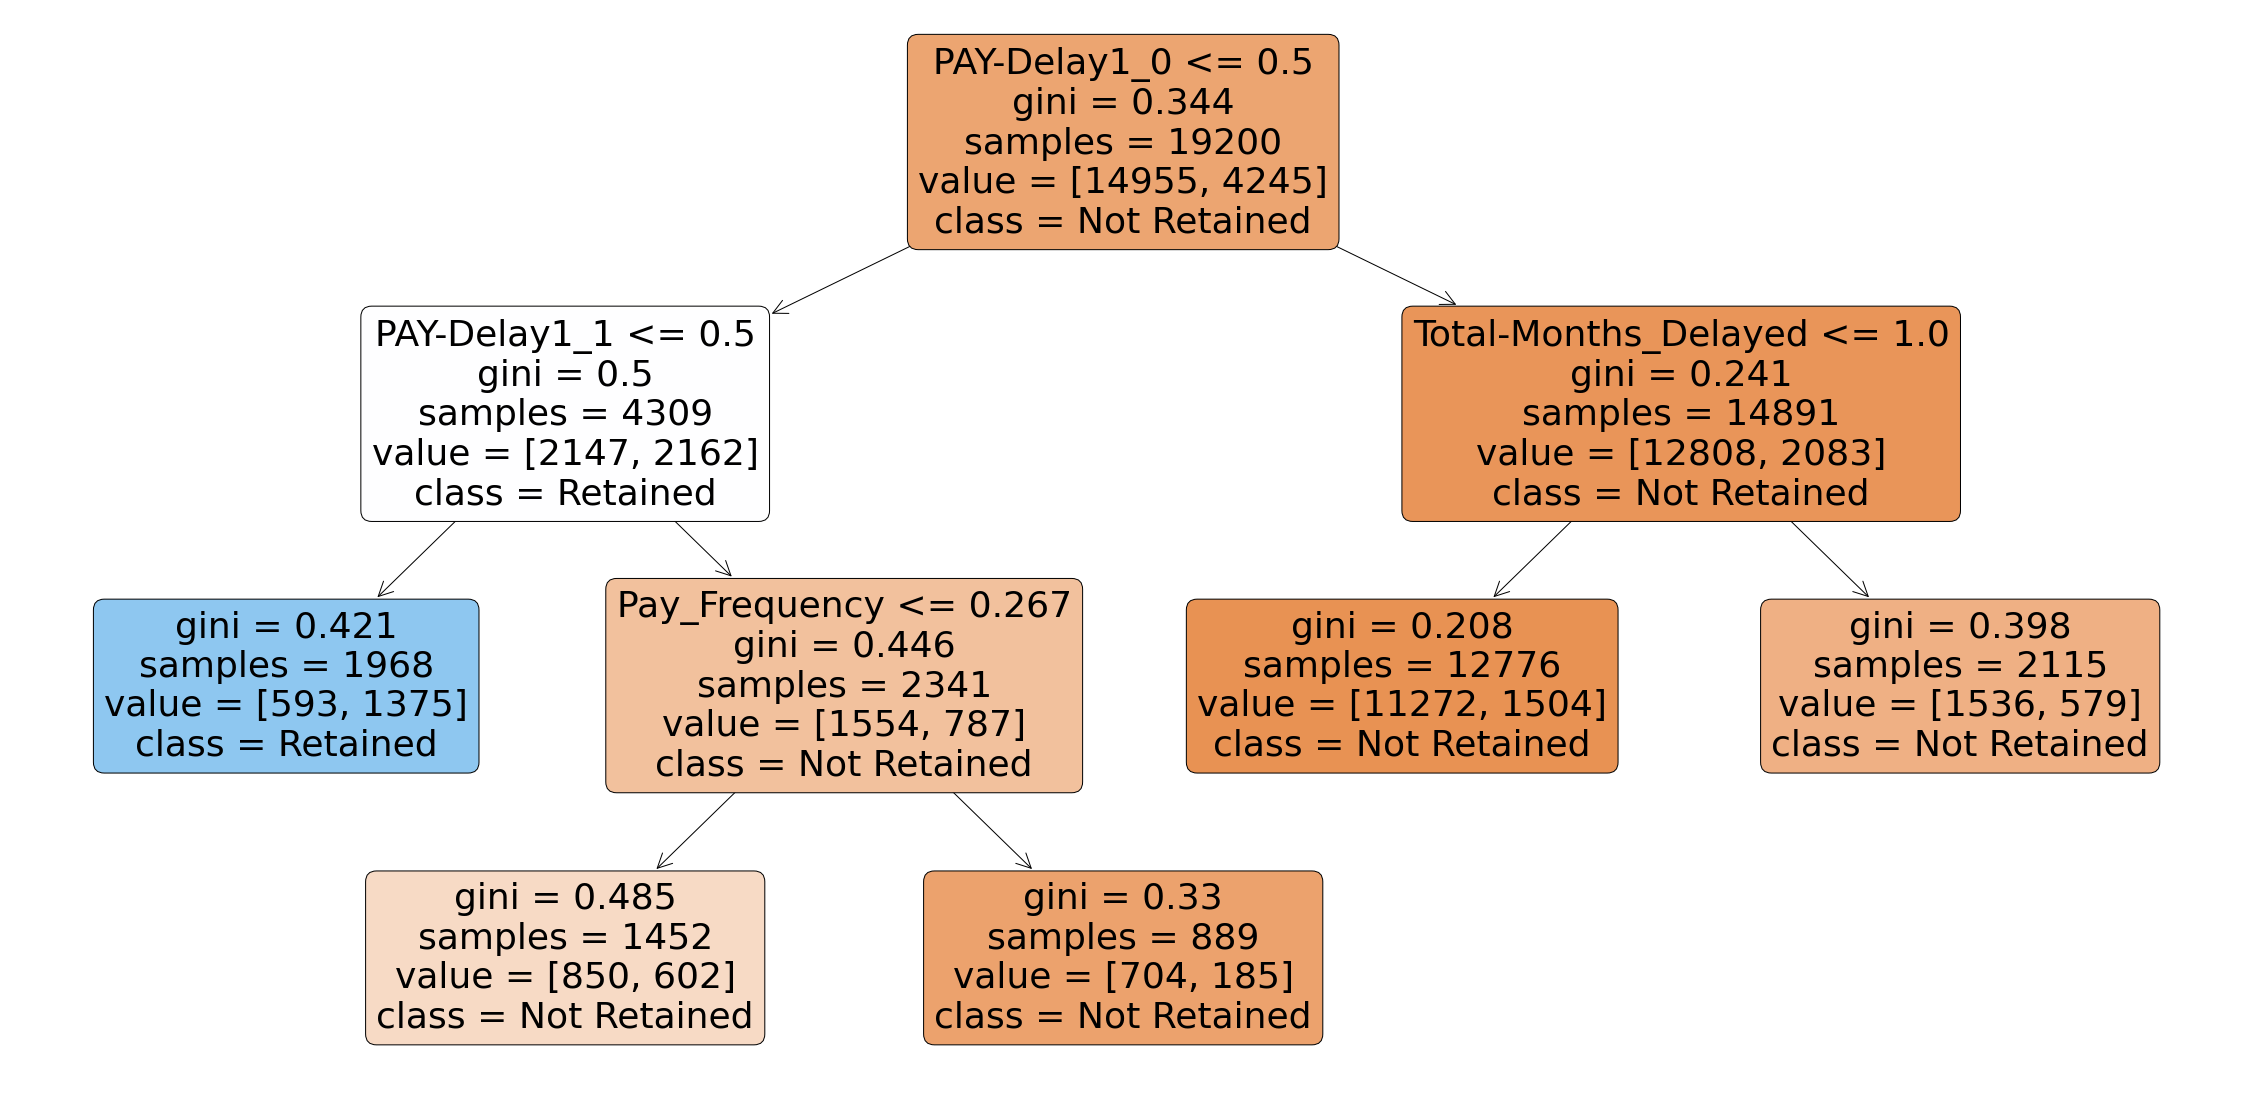

In [ ]:
# Visualizing the resultant tree

from sklearn import tree

plt.figure(figsize=(40,20))
tree.plot_tree(classifier_DT.fit(X_train, y_train), feature_names = X_train.columns, filled = True, 
               class_names = ['Not Retained', 'Retained'], rounded = True)
print('CART tree with 5 leafs')


Metrics of the CART model: 

Confusion matrix: 
[[2975  432]
 [ 764  629]]
                                   Accuracy: 0.7508333333333334
                   SENSITIVITY (aka RECALL): 0.7956672907194438
                 SPECIFICITY (aka FALL-OUT): 0.592836946277097
 POSITIVE PREDICTIVE VALUE, (aka PRECISION): 0.8732022307014969
                 NEGATIVE PREDICTIVE VALUE): 0.4515434314429289


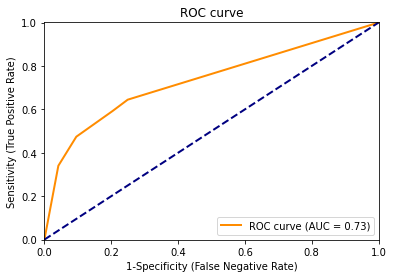

 AUC: 0.73221418076121


In [ ]:
# Lets look at the model metrics

print('Metrics of the CART model: \n')

cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix: \n" + str(cm))

print("                                   Accuracy: " + str(custom_accuracy_score(y_test, y_pred))) 
print("                   SENSITIVITY (aka RECALL): " + str(custom_sensitivity_score(y_test, y_pred)))
print("                 SPECIFICITY (aka FALL-OUT): " + str(custom_specificity_score(y_test, y_pred)))
print(" POSITIVE PREDICTIVE VALUE, (aka PRECISION): " + str(custom_ppv_score(y_test, y_pred)))
print("                 NEGATIVE PREDICTIVE VALUE): " + str(custom_npv_score(y_test, y_pred)))

plot_roc(y_test, y_pred_prob)
print(" AUC: " + str(roc_auc_score(y_test, y_pred_prob)))

In [ ]:
DecisionTreeClassifier() # display what those hyper-parameters are and their default values

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

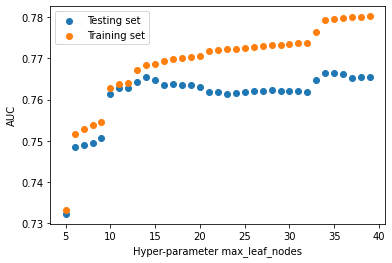

In [ ]:
# Tuning hyper-parameter max_leaf_nodes

n_max_leaf_nodes = range(5,40) # Lets train the models with 5, 6, 7, ... 40 leafs

# for each model calculate AUC for testing 
array = []
for n in n_max_leaf_nodes:
    
    classifier_DT = tree.DecisionTreeClassifier(criterion = 'gini', max_leaf_nodes = n)
    classifier_DT = classifier_DT.fit(X_train, y_train)
    
    y_pred_prob = classifier_DT.predict_proba(X_test)[:,1]   
    y_pred = np.where(y_pred_prob > class_threshold, 1, 0)

    array.append([n,roc_auc_score(y_test, y_pred_prob)])

# plot the testing set AUCs
array = pd.DataFrame(array)
plt.scatter(array[0],array[1])

# now for each model calculate AUC on training 
array = []
for n in n_max_leaf_nodes:

    classifier_DT = tree.DecisionTreeClassifier(criterion = 'gini', max_leaf_nodes = n)
    classifier_DT = classifier_DT.fit(X_train, y_train)
    
    y_pred_prob = classifier_DT.predict_proba(X_train)[:,1] 
    y_pred = np.where(y_pred_prob > class_threshold, 1, 0)

    array.append([n,roc_auc_score(y_train, y_pred_prob)])

# plot the training set AUCs
array = pd.DataFrame(array)
plt.scatter(array[0],array[1])

# label the axes on the plot
plt.xlabel('Hyper-parameter max_leaf_nodes')
plt.ylabel('AUC')

# add the legend
plt.legend(['Testing set','Training set'])


In [ ]:
# lets train the model with 8 leafs
classifier_DT = tree.DecisionTreeClassifier(criterion = 'gini', max_leaf_nodes = 8)
classifier_DT = classifier_DT.fit(X_train, y_train)

# obtain its predictions
y_pred_prob = classifier_DT.predict_proba(X_test)[:,1]   
y_pred = np.where(y_pred_prob > class_threshold, 1, 0)

# calclate and print the AUC
print(" AUC: " + str(roc_auc_score(y_test, y_pred_prob)))

 AUC: 0.7494869650944688


# Method №3: Random Forest

In [ ]:
# Define a random forest model and call it classifier_RF
classifier_RF = RandomForestClassifier(random_state=77300)

# Train the model classifier_RF on the training data
classifier_RF.fit(X_train, y_train)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=77300,
                       verbose=0, warm_start=False)

Metrics of the Random Forest model: 

Confusion matrix: 
[[2828  378]
 [ 911  683]]
                                   Accuracy: 0.7314583333333333
                   SENSITIVITY (aka RECALL): 0.7563519657662476
                 SPECIFICITY (aka FALL-OUT): 0.6437323279924599
 POSITIVE PREDICTIVE VALUE, (aka PRECISION): 0.8820960698689956
                 NEGATIVE PREDICTIVE VALUE): 0.42848180677540776


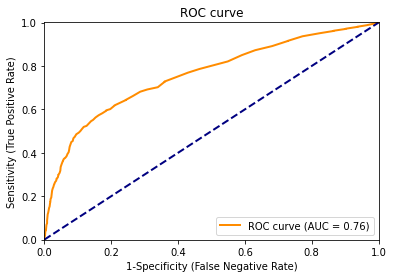

 AUC: 0.7584404041361416


In [ ]:
# Use the trained model to predict testing data
y_pred_prob = classifier_RF.predict_proba(X_test)[:,1] # probabilities 
y_pred = np.where(y_pred_prob > class_threshold, 1, 0) # classification

# Lets look at the model metrics

print('Metrics of the Random Forest model: \n')

cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix: \n" + str(cm))

print("                                   Accuracy: " + str(custom_accuracy_score(y_test, y_pred))) 
print("                   SENSITIVITY (aka RECALL): " + str(custom_sensitivity_score(y_test, y_pred)))
print("                 SPECIFICITY (aka FALL-OUT): " + str(custom_specificity_score(y_test, y_pred)))
print(" POSITIVE PREDICTIVE VALUE, (aka PRECISION): " + str(custom_ppv_score(y_test, y_pred)))
print("                 NEGATIVE PREDICTIVE VALUE): " + str(custom_npv_score(y_test, y_pred)))

plot_roc(y_test, y_pred_prob)
print(" AUC: " + str(roc_auc_score(y_test, y_pred_prob)))


Optimized hyper-parameters:{'n_estimators': 500}
Metrics of the Random Forest model with the optimized hyper-parameter for the "number of trees": 

Confusion matrix: 
[[2850  889]
 [ 375  686]]
                                   Accuracy: 0.7366666666666667
                   SENSITIVITY (aka RECALL): 0.7622358919497192
                 SPECIFICITY (aka FALL-OUT): 0.646559849198869
 POSITIVE PREDICTIVE VALUE, (aka PRECISION): 0.8837209302325582
                 NEGATIVE PREDICTIVE VALUE): 0.43555555555555553


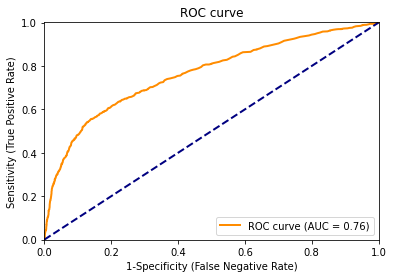

 AUC: 0.7627851625843599


In [ ]:
# Hyper-parameter tuning ("optimization") using the function GridSearchCV for maximizing AUC
score_func = make_scorer(roc_auc_score, greater_is_better=True)

n_trees = [100, 200, 300, 400, 500, 600] 
Grid_srch_parameters_list = [ [{'n_estimators':n_trees}] ] 

# we will apply a 5-fold cross-validation and call the resultant function "grid_search"
grid_search = GridSearchCV(estimator = classifier_RF, cv = 5, param_grid = Grid_srch_parameters_list[0], scoring = score_func,
                              return_train_score = True) 

# apply function grid_search to the training data, call the resultand best model grid_search_RF
grid_search_RF = grid_search.fit(X_train, y_train)

# use the best model to predict the testing data
y_pred_prob = grid_search_RF.predict_proba(X_test)[:,1] # probabilities  
y_pred = np.where(y_pred_prob > class_threshold, 1, 0) # classification

print('Optimized hyper-parameters:' + str(grid_search.best_params_))
    
# Lets look at the model metrics

print('Metrics of the Random Forest model with the optimized hyper-parameter for the "number of trees": \n')

cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix: \n" + str(cm))

print("                                   Accuracy: " + str(custom_accuracy_score(y_test, y_pred))) 
print("                   SENSITIVITY (aka RECALL): " + str(custom_sensitivity_score(y_test, y_pred)))
print("                 SPECIFICITY (aka FALL-OUT): " + str(custom_specificity_score(y_test, y_pred)))
print(" POSITIVE PREDICTIVE VALUE, (aka PRECISION): " + str(custom_ppv_score(y_test, y_pred)))
print("                 NEGATIVE PREDICTIVE VALUE): " + str(custom_npv_score(y_test, y_pred)))

plot_roc(y_test, y_pred_prob)
print(" AUC: " + str(roc_auc_score(y_test, y_pred_prob)))


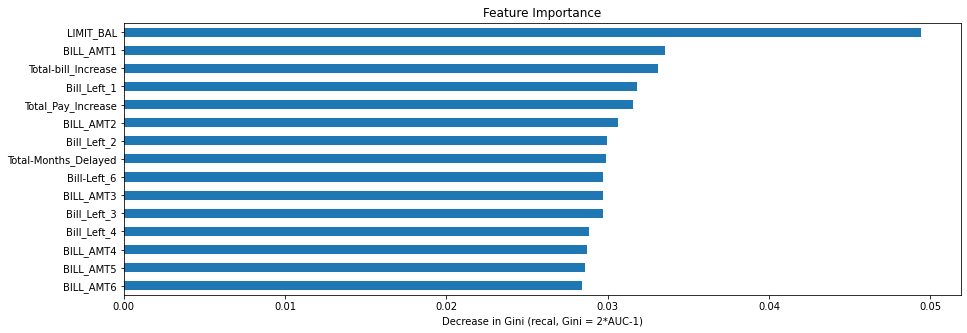

In [ ]:
# calculate feature importances
importances = grid_search_RF.best_estimator_.feature_importances_ 

# plot them
plt.figure(figsize=(15,5))
plt.title('Feature Importance')
plt.xlabel('Decrease in Gini (recal, Gini = 2*AUC-1)')
feature_importances = pd.Series(classifier_RF.feature_importances_, index=X_train.columns)
feature_importances.nlargest(15).sort_values().plot(kind='barh', align='center')

# Method №4: Gradient Boosting Machine

In [ ]:
# Define the gradient boosting machine model and call it classifier_GBM
classifier_GBM = GradientBoostingClassifier(random_state=77300)

# Train the model classifier_GBM on the training data
classifier_GBM.fit(X_train, y_train)


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=77300, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

Metrics of the Gradient Boosting Machine model: 

Confusion matrix: 
[[3006  733]
 [ 376  685]]
                                   Accuracy: 0.7689583333333333
                   SENSITIVITY (aka RECALL): 0.8039582776143354
                 SPECIFICITY (aka FALL-OUT): 0.6456173421300659
 POSITIVE PREDICTIVE VALUE, (aka PRECISION): 0.8888231815493791
                 NEGATIVE PREDICTIVE VALUE): 0.4830747531734838


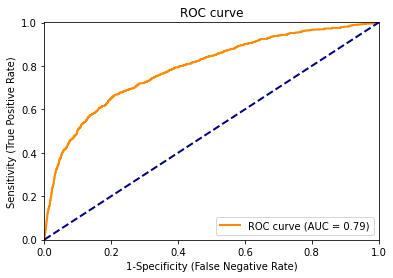

 AUC: 0.7904677471761969


In [ ]:
# Use the trained model to predict testing data
y_pred_prob = classifier_GBM.predict_proba(X_test)[:,1] # probabilities 
y_pred = np.where(y_pred_prob > class_threshold, 1, 0) # classification

# Lets look at the model metrics

print('Metrics of the Gradient Boosting Machine model: \n')

cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix: \n" + str(cm))

print("                                   Accuracy: " + str(custom_accuracy_score(y_test, y_pred))) 
print("                   SENSITIVITY (aka RECALL): " + str(custom_sensitivity_score(y_test, y_pred)))
print("                 SPECIFICITY (aka FALL-OUT): " + str(custom_specificity_score(y_test, y_pred)))
print(" POSITIVE PREDICTIVE VALUE, (aka PRECISION): " + str(custom_ppv_score(y_test, y_pred)))
print("                 NEGATIVE PREDICTIVE VALUE): " + str(custom_npv_score(y_test, y_pred)))

plot_roc(y_test, y_pred_prob)
print(" AUC: " + str(roc_auc_score(y_test, y_pred_prob)))

Optimized hyper-parameters:{'learning_rate': 0.01, 'n_estimators': 600}
Metrics of the Gradient Boosting Machine model with the optimized hyper-parameters": 

Confusion matrix: 
[[3032  707]
 [ 381  680]]
                                   Accuracy: 0.7733333333333333
                   SENSITIVITY (aka RECALL): 0.810912008558438
                 SPECIFICITY (aka FALL-OUT): 0.6409048067860509
 POSITIVE PREDICTIVE VALUE, (aka PRECISION): 0.8883680046879578
                 NEGATIVE PREDICTIVE VALUE): 0.49026676279740444


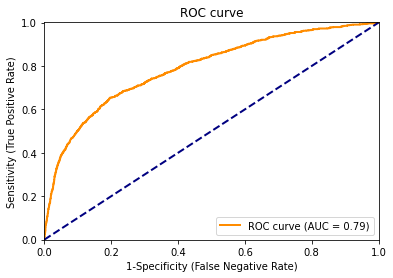

 AUC: 0.7902321834276556


In [ ]:
# Hyper-parameter tuning ("optimization") using the function GridSearchCV for maximizing AUC
score_func = make_scorer(roc_auc_score, greater_is_better=True)

# as an example, we will tune two parameters
n_trees = [100, 200, 300, 400, 500, 600]
learning_rates = [0.01, 0.1] 

Grid_srch_parameters_list = [ [{'n_estimators':n_trees, 'learning_rate': learning_rates}] ] 

# we will apply a 5-fold cross-validation and call the resultant function "grid_search"
grid_search = GridSearchCV(estimator = classifier_GBM, cv = 5, param_grid = Grid_srch_parameters_list[0], scoring = score_func,
                              return_train_score = True) 

# # apply function grid_search to the training data, call the resultant best model grid_search_GBM
grid_search_GBM = grid_search.fit(X_train, y_train)

# use the best model to predict the testing data 
y_pred_prob = grid_search_GBM.predict_proba(X_test)[:,1] # probabilities
y_pred = np.where(y_pred_prob > class_threshold, 1, 0) # classification

print('Optimized hyper-parameters:' + str(grid_search.best_params_))

# Lets look at the model metrics

print('Metrics of the Gradient Boosting Machine model with the optimized hyper-parameters": \n')

cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix: \n" + str(cm))

print("                                   Accuracy: " + str(custom_accuracy_score(y_test, y_pred))) 
print("                   SENSITIVITY (aka RECALL): " + str(custom_sensitivity_score(y_test, y_pred)))
print("                 SPECIFICITY (aka FALL-OUT): " + str(custom_specificity_score(y_test, y_pred)))
print(" POSITIVE PREDICTIVE VALUE, (aka PRECISION): " + str(custom_ppv_score(y_test, y_pred)))
print("                 NEGATIVE PREDICTIVE VALUE): " + str(custom_npv_score(y_test, y_pred)))

plot_roc(y_test, y_pred_prob)
print(" AUC: " + str(roc_auc_score(y_test, y_pred_prob)))


In [ ]:
# Validation = pd.DataFrame(data={"ID": validation_ID,"Actual":y_test, "Predicted": y_pred})
# Validation.to_csv("Validation_With.csv",sep = ',', index= False)

# Method №5: Support Vector Machines

In [ ]:
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

svm_estimators = []
svm_estimators.append(('standardize', StandardScaler())) # scale the data
svm_estimators.append(('svm', svm.SVC(probability=True)))
     
# Define the support vectors machine model and call it classifier_SVM
Classifier_SVM = Pipeline(svm_estimators, verbose=False)

# Train the model classifier_SVM on the training data
Classifier_SVM.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('standardize',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svm',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='scale', kernel='rbf', max_iter=-1, probability=True,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

Metrics of the Support Vector Machines model: 

Confusion matrix: 
[[3525  214]
 [ 630  431]]
                                   Accuracy: 0.8241666666666667
                   SENSITIVITY (aka RECALL): 0.9427654453062316
                 SPECIFICITY (aka FALL-OUT): 0.4062205466540999
 POSITIVE PREDICTIVE VALUE, (aka PRECISION): 0.8483754512635379
                 NEGATIVE PREDICTIVE VALUE): 0.6682170542635659


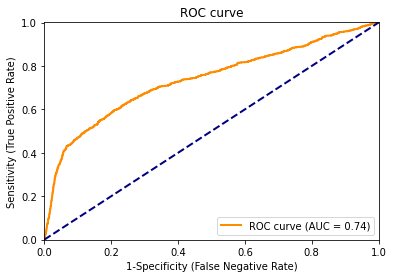

 AUC: 0.7359820664020051


In [ ]:
# use the fitted model to predict the testing data 
y_pred_prob = Classifier_SVM.predict_proba(X_test)[:,1] # probabilities
y_pred = np.where(y_pred_prob > class_threshold, 1, 0) # classification

# Lets look at the model metrics

print('Metrics of the Support Vector Machines model: \n')

cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix: \n" + str(cm))

print("                                   Accuracy: " + str(custom_accuracy_score(y_test, y_pred))) 
print("                   SENSITIVITY (aka RECALL): " + str(custom_sensitivity_score(y_test, y_pred)))
print("                 SPECIFICITY (aka FALL-OUT): " + str(custom_specificity_score(y_test, y_pred)))
print(" POSITIVE PREDICTIVE VALUE, (aka PRECISION): " + str(custom_ppv_score(y_test, y_pred)))
print("                 NEGATIVE PREDICTIVE VALUE): " + str(custom_npv_score(y_test, y_pred)))

plot_roc(y_test, y_pred_prob)
print(" AUC: " + str(roc_auc_score(y_test, y_pred_prob)))

# Method №6: Artificial Neural Networks ("Deep Learning") with Tensor Flow

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier


In [ ]:
# Define the architecture and optimization metrics for the network
def create_model():
    model = keras.Sequential([
        layers.Dense(128,  activation="relu", name="hidden-dense-128-layer-1"),
        layers.Dropout(0.3),
        layers.Dense(64, activation="relu", name="hidden-dense-64-layer-2"),
        layers.Dropout(0.2),
        layers.Dense(1, activation='sigmoid', name="output-layer"),
    ])
    adam = tf.keras.optimizers.Adam()
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    return model

nn_estimators = []
nn_estimators.append(('standardize', StandardScaler())) #scale the data
nn_estimators.append(('mlp', KerasClassifier(build_fn=create_model, epochs=30, batch_size=128, validation_split=0.2))) # compile the model

# Define the TensorFlow Neural Network model and call it classifier_TF_NN
Classifier_TF_NN = Pipeline(nn_estimators, verbose=False)

# Train the model classifier_SVM on the training data
Classifier_TF_NN.fit(X_train, y_train)

Epoch 1/30
120/120 [==============================] - 1s 5ms/step - loss: 0.4980 - accuracy: 0.7857 - val_loss: 0.4535 - val_accuracy: 0.8104
Epoch 2/30
120/120 [==============================] - 0s 4ms/step - loss: 0.4483 - accuracy: 0.8175 - val_loss: 0.4517 - val_accuracy: 0.8141
Epoch 3/30
120/120 [==============================] - 0s 4ms/step - loss: 0.4378 - accuracy: 0.8219 - val_loss: 0.4502 - val_accuracy: 0.8120
Epoch 4/30
120/120 [==============================] - 0s 4ms/step - loss: 0.4352 - accuracy: 0.8212 - val_loss: 0.4494 - val_accuracy: 0.8117
Epoch 5/30
120/120 [==============================] - 0s 4ms/step - loss: 0.4313 - accuracy: 0.8238 - val_loss: 0.4487 - val_accuracy: 0.8130
Epoch 6/30
120/120 [==============================] - 0s 4ms/step - loss: 0.4286 - accuracy: 0.8242 - val_loss: 0.4452 - val_accuracy: 0.8133
Epoch 7/30
120/120 [==============================] - 0s 4ms/step - loss: 0.4259 - accuracy: 0.8239 - val_loss: 0.4478 - val_accuracy: 0.8148
Epoch 

Pipeline(memory=None,
         steps=[('standardize',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('mlp',
                 <tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7f7ff8c4d7d0>)],
         verbose=False)

Metrics of the Tensor Flow Neural Network model: 

Confusion matrix: 
[[2930  809]
 [ 392  669]]
                                   Accuracy: 0.7497916666666666
                   SENSITIVITY (aka RECALL): 0.7836319871623428
                 SPECIFICITY (aka FALL-OUT): 0.6305372290292177
 POSITIVE PREDICTIVE VALUE, (aka PRECISION): 0.8819987959060807
                 NEGATIVE PREDICTIVE VALUE): 0.45263870094722597


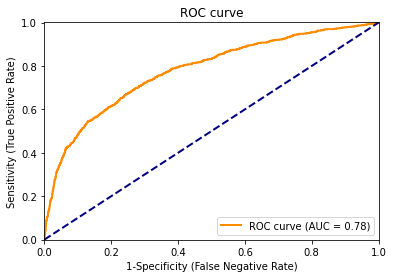

 AUC: 0.7791750555005332


In [ ]:
# use the fitted model to predict the testing data 
y_pred_prob = Classifier_TF_NN.predict_proba(X_test)[:,1] # probabilities
y_pred = np.where(y_pred_prob > class_threshold, 1, 0) # classification

# Lets look at the model metrics

print('Metrics of the Tensor Flow Neural Network model: \n')

cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix: \n" + str(cm))

print("                                   Accuracy: " + str(custom_accuracy_score(y_test, y_pred))) 
print("                   SENSITIVITY (aka RECALL): " + str(custom_sensitivity_score(y_test, y_pred)))
print("                 SPECIFICITY (aka FALL-OUT): " + str(custom_specificity_score(y_test, y_pred)))
print(" POSITIVE PREDICTIVE VALUE, (aka PRECISION): " + str(custom_ppv_score(y_test, y_pred)))
print("                 NEGATIVE PREDICTIVE VALUE): " + str(custom_npv_score(y_test, y_pred)))

plot_roc(y_test, y_pred_prob)
print(" AUC: " + str(roc_auc_score(y_test, y_pred_prob)))

# Prediction

In [ ]:
pred_sex = pred['SEX']
pred_ID = pred_new['ID']
pred_default = pred_new['DEFAULT']
X_pred = pred_new.drop(columns=['DEFAULT', 'ID'], axis = 1).copy()

In [ ]:
# Since the GBM model with optimized hyper-parameters obtained the higest AUC, lets take that; recall it is called grid_search_RF
y_pred_prob = grid_search_GBM.predict_proba(X_pred)[:,1] # probabilities
y_pred_default = np.where(y_pred_prob > class_threshold, 1, 0) # classification default
y_pred_issued = np.where(y_pred_prob > class_threshold, 0, 1) # classification issued

In [ ]:
# Lets add the ID column to know "who is who"
Prediction = pd.DataFrame(data={"ISSUED":y_pred_issued})
Predicted_Probability = pd.DataFrame(data={"ID": pred_ID, "SEX": pred_sex ,"PROBABILITY OF DEFAULT":y_pred_prob, "ISSUED": y_pred_issued, "DEFAULT":y_pred_default})

In [ ]:
# Export the predictions into a CSV file
Prediction.to_csv("Predicted_Issued_with_rev.csv",sep = ',', index = False, header= False)
Predicted_Probability.to_csv("Predicted_Issued_With_rev_Prob.csv",sep = ',')